# Testing boosting, ensemble and linear models to predict NYC taxi fares

### importing the dataframe and getting ready for xgboost

In [37]:
#libraries we need
import pandas as pd
import numpy as np
import datetime as date
import matplotlib.pyplot as plt
from pandas import read_csv
import sklearn
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import XGBRegressor
from scipy.stats import sem

df = pd.read_csv("C:/Users/zubiz/Desktop/NYC Third Year project/taxi_tripdata.csv")

#cleans the dataframe and fills in empty values
df = df.drop(['ehail_fee',"payment_type","store_and_fwd_flag"], axis = 1)
for list_cols in df.columns:    
    df[list_cols] = df[list_cols].fillna(0)
df.head()

#splits the object into a datetime object
df['lpep_pickup_datetime'] = pd.to_datetime(df['lpep_pickup_datetime'], errors='coerce')
df['lpep_dropoff_datetime'] = pd.to_datetime(df['lpep_dropoff_datetime'], errors='coerce')
df['time_taken'] = df['lpep_dropoff_datetime'] - df['lpep_pickup_datetime']
df['time_taken'] = df['time_taken'].dt.total_seconds().div(60).astype(float)
df['day'] = pd.to_datetime(df['lpep_pickup_datetime']).dt.weekday
df['hour'] = pd.to_datetime(df['lpep_pickup_datetime']).dt.hour
df["PU_time"] = pd.to_datetime(df['lpep_pickup_datetime'])
df["DO_time"] = pd.to_datetime(df['lpep_dropoff_datetime'])
df = df.drop(['lpep_pickup_datetime','lpep_dropoff_datetime'], axis = 1)


#outliers cleaned
interval_one = df["time_taken"].quantile(0.001)
interval_two = df["time_taken"].quantile(0.995)
df = df.drop(df[(df['time_taken'] < interval_one) | (df['time_taken'] > interval_two)].index)

df.head()

C:\Users\zubiz\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,VendorID,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,trip_type,congestion_surcharge,time_taken,day,hour,PU_time,DO_time
0,1.0,1.0,74,168,1.0,1.20,6.0,0.5,0.5,0.00,0.0,0.3,7.30,1.0,0.0,4.733333,3,0,2021-07-01 00:30:52,2021-07-01 00:35:36
1,2.0,1.0,116,265,2.0,13.69,42.0,0.5,0.5,0.00,0.0,0.3,43.30,1.0,0.0,35.916667,3,0,2021-07-01 00:25:36,2021-07-01 01:01:31
2,2.0,1.0,97,33,1.0,0.95,6.5,0.5,0.5,2.34,0.0,0.3,10.14,1.0,0.0,6.033333,3,0,2021-07-01 00:05:58,2021-07-01 00:12:00
3,2.0,1.0,74,42,1.0,1.24,6.5,0.5,0.5,0.00,0.0,0.3,7.80,1.0,0.0,5.716667,3,0,2021-07-01 00:41:40,2021-07-01 00:47:23
4,2.0,1.0,42,244,1.0,1.10,7.0,0.5,0.5,0.00,0.0,0.3,8.30,1.0,0.0,7.233333,3,0,2021-07-01 00:51:32,2021-07-01 00:58:46


### Feature set and target

In [38]:
dftrain = df[["PULocationID","DOLocationID","passenger_count","trip_distance","day","hour","time_taken",
              "trip_type","fare_amount"]]
dftrain = dftrain.drop(dftrain[(dftrain['passenger_count'] == 0)].index)
dftrain = dftrain.drop(dftrain[(dftrain['trip_type'] == 0)].index)
dftrain = dftrain.drop(dftrain[(dftrain['fare_amount'] < 0)].index)
dftrain = dftrain.drop(dftrain[(dftrain['trip_distance'] < 0)].index)
dftrain.describe()

,PULocationID,DOLocationID,passenger_count,trip_distance,day,hour,time_taken,trip_type,fare_amount
count,50516.000000,50516.000000,50516.000000,50516.000000,50516.000000,50516.000000,50516.000000,50516.000000,50516.000000
mean,98.600424,135.018073,1.310476,3.473876,2.990063,13.691108,16.159907,1.033514,14.950447
std,64.572398,77.619544,0.986602,4.528978,1.852488,5.123003,15.061823,0.179977,14.169416
min,3.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.016667,1.000000,0.000000
25%,52.000000,74.000000,1.000000,1.100000,1.000000,10.000000,7.116667,1.000000,7.000000
50%,75.000000,134.000000,1.000000,1.990000,3.000000,14.000000,11.866667,1.000000,10.500000
75%,129.000000,213.000000,1.000000,3.850000,4.000000,18.000000,19.500000,1.000000,17.000000
max,265.000000,265.000000,32.000000,85.810000,6.000000,23.000000,119.000000,2.000000,480.000000


In [39]:
X = dftrain[["PULocationID","DOLocationID","passenger_count","trip_distance","day","hour","time_taken",
              "trip_type",]]
X = pd.get_dummies(X, columns= ['PULocationID', 'DOLocationID','trip_type','day','hour','passenger_count'])
y = dftrain['fare_amount']

In [40]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(X.head(11))

,trip_distance,time_taken,PULocationID_3,PULocationID_5,PULocationID_6,PULocationID_7,PULocationID_8,PULocationID_9,PULocationID_10,PULocationID_11,PULocationID_14,PULocationID_15,PULocationID_16,PULocationID_17,PULocationID_18,PULocationID_19,PULocationID_20,PULocationID_21,PULocationID_22,PULocationID_23,PULocationID_24,PULocationID_25,PULocationID_26,PULocationID_27,PULocationID_28,PULocationID_29,PULocationID_31,PULocationID_32,PULocationID_33,PULocationID_34,PULocationID_35,PULocationID_36,PULocationID_37,PULocationID_38,PULocationID_39,PULocationID_40,PULocationID_41,PULocationID_42,PULocationID_43,PULocationID_44,PULocationID_45,PULocationID_46,PULocationID_47,PULocationID_48,PULocationID_49,PULocationID_51,PULocationID_52,PULocationID_53,PULocationID_54,PULocationID_55,PULocationID_56,PULocationID_57,PULocationID_58,PULocationID_59,PULocationID_60,PULocationID_61,PULocationID_62,PULocationID_63,PULocationID_64,PULocationID_65,PULocationID_66,PULocationID_67,PULocationID_69,PULocationID_70,PULocationID_71,PULocationID_72,PULocationID_73,PULocationID_74,PULocationID_75,PULocationID_76,PULocationID_77,PULocationID_78,PULocationID_80,PULocationID_81,PULocationID_82,PULocationID_83,PULocationID_84,PULocationID_85,PULocationID_86,PULocationID_88,PULocationID_89,PULocationID_91,PULocationID_92,PULocationID_93,PULocationID_94,PULocationID_95,PULocationID_96,PULocationID_97,PULocationID_98,PULocationID_99,PULocationID_100,PULocationID_101,PULocationID_102,PULocationID_106,PULocationID_108,PULocationID_111,PULocationID_112,PULocationID_115,PULocationID_116,PULocationID_117,PULocationID_118,PULocationID_119,PULocationID_120,PULocationID_121,PULocationID_122,PULocationID_123,PULocationID_124,PULocationID_126,PULocationID_127,PULocationID_128,PULocationID_129,PULocationID_130,PULocationID_131,PULocationID_132,PULocationID_133,PULocationID_134,PULocationID_135,PULocationID_136,PULocationID_137,PULocationID_138,PULocationID_139,PULocationID_140,PULocationID_141,PULocationID_145,PULocationID_146,PULocationID_147,PULocationID_149,PULocationID_150,PULocationID_151,PULocationID_152,PULocationID_153,PULocationID_154,PULocationID_155,PULocationID_156,PULocationID_157,PULocationID_159,PULocationID_160,PULocationID_163,PULocationID_165,PULocationID_166,PULocationID_167,PULocationID_168,PULocationID_169,PULocationID_170,PULocationID_171,PULocationID_172,PULocationID_173,PULocationID_174,PULocationID_175,PULocationID_177,PULocationID_178,PULocationID_179,PULocationID_180,PULocationID_181,PULocationID_182,PULocationID_183,PULocationID_184,PULocationID_185,PULocationID_188,PULocationID_189,PULocationID_190,PULocationID_191,PULocationID_192,PULocationID_193,PULocationID_194,PULocationID_195,PULocationID_196,PULocationID_197,PULocationID_198,PULocationID_200,PULocationID_201,PULocationID_202,PULocationID_203,PULocationID_205,PULocationID_206,PULocationID_207,PULocationID_208,PULocationID_210,PULocationID_212,PULocationID_213,PULocationID_215,PULocationID_216,PULocationID_217,PULocationID_218,PULocationID_219,PULocationID_220,PULocationID_221,PULocationID_222,PULocationID_223,PULocationID_225,PULocationID_226,PULocationID_227,PULocationID_228,PULocationID_231,PULocationID_235,PULocationID_236,PULocationID_238,PULocationID_239,PULocationID_240,PULocationID_241,PULocationID_242,PULocationID_243,PULocationID_244,PULocationID_245,PULocationID_247,PULocationID_248,PULocationID_249,PULocationID_250,PULocationID_252,PULocationID_253,PULocationID_254,PULocationID_255,PULocationID_256,PULocationID_257,PULocationID_258,PULocationID_259,PULocationID_260,PULocationID_262,PULocationID_263,PULocationID_264,PULocationID_265,DOLocationID_1,DOLocationID_3,DOLocationID_4,DOLocationID_5,DOLocationID_6,DOLocationID_7,DOLocationID_8,DOLocationID_9,DOLocationID_10,DOLocationID_11,DOLocationID_12,DOLocationID_13,DOLocationID_14,DOLocationID_15,DOLocationID_16,DOLocationID_17,DOLocationID_18,DOLocationID_19,DOLocationID_20,DOLocationID_21,DOLocationID_22,DOLocationID_23,D

In [41]:
X.describe()

,trip_distance,time_taken,PULocationID_3,PULocationID_5,PULocationID_6,PULocationID_7,PULocationID_8,PULocationID_9,PULocationID_10,PULocationID_11,...,hour_22,hour_23,passenger_count_1.0,passenger_count_2.0,passenger_count_3.0,passenger_count_4.0,passenger_count_5.0,passenger_count_6.0,passenger_count_7.0,passenger_count_32.0
count,50516.000000,50516.000000,50516.000000,50516.000000,50516.000000,50516.000000,50516.000000,50516.000000,50516.000000,50516.000000,...,50516.000000,50516.000000,50516.000000,50516.000000,50516.000000,50516.000000,50516.000000,50516.000000,50516.000000,50516.000000
mean,3.473876,16.159907,0.000139,0.000455,0.000099,0.026328,0.000059,0.000059,0.000831,0.000376,...,0.027239,0.023557,0.863033,0.076689,0.012234,0.003583,0.024289,0.020112,0.000040,0.000020
std,4.528978,15.061823,0.011771,0.021333,0.009948,0.160111,0.007706,0.007706,0.028823,0.019390,...,0.162780,0.151665,0.343815,0.266099,0.109929,0.059752,0.153947,0.140386,0.006292,0.004449
min,0.000000,0.016667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.100000,7.116667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.990000,11.866667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.850000,19.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,85.810000,119.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [42]:
# Removing outliers using zscore
def remove_outliers(X, y):
    
    kpi = pd.Series(y).name
    
    from scipy.stats import zscore
    
    y = pd.DataFrame(y)
    y['zscore'] = zscore(y[kpi],axis=0)

    #Remove outliers
    mean_std_ratio = y[kpi].describe()['std'] / y[kpi].describe()['mean']

    #Create new df with outliers removed
    rows_to_keep = y['zscore'] <  (1 / mean_std_ratio)

    #Print % of rows removed
    print(f"Number of rows to be removed {X.shape[0] - X[rows_to_keep].shape[0] } ")
    print(f"% of rows kept after outliers removed { (1 - (X.shape[0] - X[rows_to_keep].shape[0]) / X.shape[0]):.1%}")

    X = X[rows_to_keep]
    y = y[rows_to_keep]

    #Set y and X
    y = y[kpi]
        
    return X, y

features_clean, target_clean = remove_outliers(X, y)
X_train, X_test, y_train, y_test = train_test_split(features_clean, target_clean, test_size=0.2)
features_clean.describe()

Number of rows to be removed 4869 
% of rows kept after outliers removed 90.4%


,trip_distance,time_taken,PULocationID_3,PULocationID_5,PULocationID_6,PULocationID_7,PULocationID_8,PULocationID_9,PULocationID_10,PULocationID_11,...,hour_22,hour_23,passenger_count_1.0,passenger_count_2.0,passenger_count_3.0,passenger_count_4.0,passenger_count_5.0,passenger_count_6.0,passenger_count_7.0,passenger_count_32.0
count,45647.000000,45647.000000,45647.000000,45647.000000,45647.000000,45647.000000,45647.000000,45647.000000,45647.000000,45647.000000,...,45647.000000,45647.000000,45647.000000,45647.000000,45647.000000,45647.000000,45647.000000,45647.000000,45647.000000,45647.0
mean,2.407438,12.653012,0.000131,0.000022,0.000022,0.027362,0.000066,0.000022,0.000416,0.000263,...,0.027121,0.023244,0.865752,0.072119,0.011633,0.003177,0.025544,0.021754,0.000022,0.0
std,2.040185,8.473569,0.011464,0.004681,0.004681,0.163138,0.008107,0.004681,0.020398,0.016212,...,0.162438,0.150678,0.340922,0.258687,0.107227,0.056272,0.157772,0.145881,0.004681,0.0
min,0.000000,0.016667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,1.070000,6.733333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
50%,1.820000,10.966667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
75%,3.160000,16.733333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
max,41.800000,116.316667,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0


### Training a model

In [43]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

def train_regressor(learner, X_train, X_test, y_train, y_test):
    
    reg = learner
    reg = reg.fit(X_train, y_train)
    predictions_train = reg.predict(X_train)
    predictions_test = reg.predict(X_test)
        
    return predictions_train, predictions_test, reg

def evaluate_regressor(learner, X_train, X_test, y_train, y_test):
    
    predictions_train, predictions_test, reg = train_regressor(learner, X_train, X_test, y_train, y_test)
    
    metrics = pd.DataFrame(
    {"r2_score":[r2_score(y_test, predictions_test)],
    "adjusted_r2":[1 - (1-reg.score(X_test, y_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)],
    "MSE":[mean_squared_error(y_test, predictions_test)],
    "RMSE":[sqrt(mean_squared_error(y_test, predictions_test))],
    "MAE": [mean_absolute_error(y_test, predictions_test)],
    "learner":[str(reg)],
    "Target":[y_train.name]}
    )
    
    return metrics, reg

def evaluate_multiple_regressors(learners, X_train, X_test, y_train, y_test):
    
    metrics = pd.DataFrame(columns=['r2_score','adjusted_r2','MSE','RMSE','MAE','learner','Target'])
    model_store = {}
    
    for learner in learners:
        
        learner_metrics, learner_reg = evaluate_regressor(learner, X_train, X_test, y_train, y_test) 
        
        metrics = metrics.append(learner_metrics)
        model_store[str(learner)] = learner_reg
        
        print(str(learner) + " has now trained for " + str(y_train.name))
        
    return metrics, model_store

In [44]:
learners = [CatBoostRegressor(loss_function='RMSE', allow_writing_files=False), XGBRegressor(), RandomForestRegressor()]
metrics, model_store = evaluate_multiple_regressors(learners, X_train, X_test, y_train, y_test)


Learning rate set to 0.072286
0:	learn: 5.6355217	total: 10.9ms	remaining: 10.9s
1:	learn: 5.3004497	total: 23ms	remaining: 11.5s
2:	learn: 4.9941350	total: 34.7ms	remaining: 11.5s
3:	learn: 4.7036448	total: 47.2ms	remaining: 11.8s
4:	learn: 4.4330122	total: 58.5ms	remaining: 11.6s
5:	learn: 4.1827507	total: 69.3ms	remaining: 11.5s
6:	learn: 3.9540777	total: 81.5ms	remaining: 11.6s
7:	learn: 3.7389661	total: 92.7ms	remaining: 11.5s
8:	learn: 3.5430346	total: 106ms	remaining: 11.7s
9:	learn: 3.3594438	total: 117ms	remaining: 11.6s
10:	learn: 3.1970089	total: 128ms	remaining: 11.5s
11:	learn: 3.0453385	total: 139ms	remaining: 11.5s
12:	learn: 2.9049404	total: 151ms	remaining: 11.5s
13:	learn: 2.7759241	total: 162ms	remaining: 11.4s
14:	learn: 2.6595110	total: 175ms	remaining: 11.5s
15:	learn: 2.5526006	total: 186ms	remaining: 11.4s
16:	learn: 2.4561717	total: 196ms	remaining: 11.3s
17:	learn: 2.3692997	total: 208ms	remaining: 11.3s
18:	learn: 2.2881233	total: 218ms	remaining: 11.3s
19:	l

167:	learn: 1.3589921	total: 1.9s	remaining: 9.38s
168:	learn: 1.3588038	total: 1.91s	remaining: 9.37s
169:	learn: 1.3580145	total: 1.92s	remaining: 9.36s
170:	learn: 1.3569538	total: 1.93s	remaining: 9.35s
171:	learn: 1.3562913	total: 1.94s	remaining: 9.34s
172:	learn: 1.3557466	total: 1.95s	remaining: 9.33s
173:	learn: 1.3555757	total: 1.96s	remaining: 9.32s
174:	learn: 1.3548755	total: 1.97s	remaining: 9.31s
175:	learn: 1.3537174	total: 1.99s	remaining: 9.3s
176:	learn: 1.3535409	total: 2s	remaining: 9.29s
177:	learn: 1.3531697	total: 2.01s	remaining: 9.28s
178:	learn: 1.3529583	total: 2.02s	remaining: 9.26s
179:	learn: 1.3524530	total: 2.03s	remaining: 9.24s
180:	learn: 1.3514970	total: 2.04s	remaining: 9.22s
181:	learn: 1.3497474	total: 2.05s	remaining: 9.21s
182:	learn: 1.3480534	total: 2.06s	remaining: 9.19s
183:	learn: 1.3478157	total: 2.07s	remaining: 9.17s
184:	learn: 1.3473571	total: 2.08s	remaining: 9.16s
185:	learn: 1.3467964	total: 2.09s	remaining: 9.15s
186:	learn: 1.345

342:	learn: 1.2554492	total: 3.86s	remaining: 7.39s
343:	learn: 1.2551592	total: 3.87s	remaining: 7.38s
344:	learn: 1.2542625	total: 3.88s	remaining: 7.37s
345:	learn: 1.2541185	total: 3.89s	remaining: 7.36s
346:	learn: 1.2540444	total: 3.9s	remaining: 7.34s
347:	learn: 1.2537527	total: 3.91s	remaining: 7.33s
348:	learn: 1.2534743	total: 3.92s	remaining: 7.31s
349:	learn: 1.2533551	total: 3.93s	remaining: 7.3s
350:	learn: 1.2525151	total: 3.94s	remaining: 7.29s
351:	learn: 1.2518686	total: 3.95s	remaining: 7.28s
352:	learn: 1.2508660	total: 3.96s	remaining: 7.26s
353:	learn: 1.2504768	total: 3.98s	remaining: 7.25s
354:	learn: 1.2499527	total: 3.99s	remaining: 7.24s
355:	learn: 1.2494068	total: 4s	remaining: 7.23s
356:	learn: 1.2484312	total: 4.01s	remaining: 7.22s
357:	learn: 1.2477660	total: 4.02s	remaining: 7.21s
358:	learn: 1.2476772	total: 4.03s	remaining: 7.2s
359:	learn: 1.2463231	total: 4.04s	remaining: 7.18s
360:	learn: 1.2461082	total: 4.05s	remaining: 7.17s
361:	learn: 1.2448

515:	learn: 1.1850792	total: 5.58s	remaining: 5.23s
516:	learn: 1.1847625	total: 5.59s	remaining: 5.22s
517:	learn: 1.1845549	total: 5.6s	remaining: 5.21s
518:	learn: 1.1844221	total: 5.61s	remaining: 5.2s
519:	learn: 1.1843740	total: 5.62s	remaining: 5.18s
520:	learn: 1.1838289	total: 5.62s	remaining: 5.17s
521:	learn: 1.1832499	total: 5.63s	remaining: 5.16s
522:	learn: 1.1831716	total: 5.64s	remaining: 5.15s
523:	learn: 1.1825474	total: 5.65s	remaining: 5.13s
524:	learn: 1.1819995	total: 5.66s	remaining: 5.12s
525:	learn: 1.1819506	total: 5.67s	remaining: 5.11s
526:	learn: 1.1817528	total: 5.68s	remaining: 5.1s
527:	learn: 1.1815118	total: 5.69s	remaining: 5.09s
528:	learn: 1.1811041	total: 5.7s	remaining: 5.08s
529:	learn: 1.1808428	total: 5.71s	remaining: 5.06s
530:	learn: 1.1802925	total: 5.72s	remaining: 5.05s
531:	learn: 1.1795935	total: 5.73s	remaining: 5.04s
532:	learn: 1.1794912	total: 5.74s	remaining: 5.03s
533:	learn: 1.1792847	total: 5.75s	remaining: 5.02s
534:	learn: 1.17

686:	learn: 1.1374999	total: 7.48s	remaining: 3.41s
687:	learn: 1.1368148	total: 7.49s	remaining: 3.4s
688:	learn: 1.1366968	total: 7.5s	remaining: 3.39s
689:	learn: 1.1364271	total: 7.52s	remaining: 3.38s
690:	learn: 1.1357079	total: 7.53s	remaining: 3.37s
691:	learn: 1.1355728	total: 7.54s	remaining: 3.35s
692:	learn: 1.1354036	total: 7.55s	remaining: 3.34s
693:	learn: 1.1349578	total: 7.56s	remaining: 3.33s
694:	learn: 1.1347674	total: 7.57s	remaining: 3.32s
695:	learn: 1.1345894	total: 7.58s	remaining: 3.31s
696:	learn: 1.1344529	total: 7.6s	remaining: 3.3s
697:	learn: 1.1339917	total: 7.61s	remaining: 3.29s
698:	learn: 1.1336699	total: 7.62s	remaining: 3.28s
699:	learn: 1.1334002	total: 7.63s	remaining: 3.27s
700:	learn: 1.1329897	total: 7.64s	remaining: 3.26s
701:	learn: 1.1325565	total: 7.65s	remaining: 3.25s
702:	learn: 1.1324284	total: 7.66s	remaining: 3.24s
703:	learn: 1.1321739	total: 7.68s	remaining: 3.23s
704:	learn: 1.1321156	total: 7.69s	remaining: 3.22s
705:	learn: 1.13

864:	learn: 1.0953291	total: 9.43s	remaining: 1.47s
865:	learn: 1.0951980	total: 9.44s	remaining: 1.46s
866:	learn: 1.0949522	total: 9.45s	remaining: 1.45s
867:	learn: 1.0946415	total: 9.46s	remaining: 1.44s
868:	learn: 1.0944165	total: 9.47s	remaining: 1.43s
869:	learn: 1.0941814	total: 9.49s	remaining: 1.42s
870:	learn: 1.0941549	total: 9.5s	remaining: 1.41s
871:	learn: 1.0938011	total: 9.51s	remaining: 1.4s
872:	learn: 1.0935315	total: 9.52s	remaining: 1.38s
873:	learn: 1.0934543	total: 9.53s	remaining: 1.37s
874:	learn: 1.0932113	total: 9.54s	remaining: 1.36s
875:	learn: 1.0928020	total: 9.54s	remaining: 1.35s
876:	learn: 1.0925803	total: 9.55s	remaining: 1.34s
877:	learn: 1.0924294	total: 9.56s	remaining: 1.33s
878:	learn: 1.0921860	total: 9.57s	remaining: 1.32s
879:	learn: 1.0916010	total: 9.58s	remaining: 1.31s
880:	learn: 1.0914245	total: 9.59s	remaining: 1.29s
881:	learn: 1.0911823	total: 9.6s	remaining: 1.28s
882:	learn: 1.0908825	total: 9.61s	remaining: 1.27s
883:	learn: 1.0

In [45]:
metrics

,r2_score,adjusted_r2,MSE,RMSE,MAE,learner,Target
0,0.941854,0.938378,2.154434,1.467799,0.554833,<catboost.core.CatBoostRegressor object at 0x0...,fare_amount
0,0.937831,0.934115,2.303477,1.517721,0.574485,"XGBRegressor(base_score=0.5, booster=None, col...",fare_amount
0,0.934564,0.930651,2.424554,1.557098,0.538055,RandomForestRegressor(),fare_amount


The best performing model in terms of highest adjusted r2 and lowest RMSE, MSE and MAE is CatBoost model

### Evaluating the best performing model further

In [46]:
regressor = list(model_store.values())[2]
regressor

RandomForestRegressor()

In [47]:
# Make predictions on the test data
predictions = regressor.predict(X_test)

Text(0.5, 1.0, 'CatBoost: residuals v predicted values')

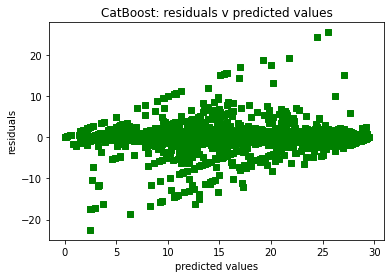

In [48]:
plt.scatter(predictions, predictions - y_test, c = 'green', marker = 's', label = 'Testing data')
plt.xlabel('predicted values')
plt.ylabel('residuals')
plt.title("CatBoost: residuals v predicted values")

-0.02401780850675376


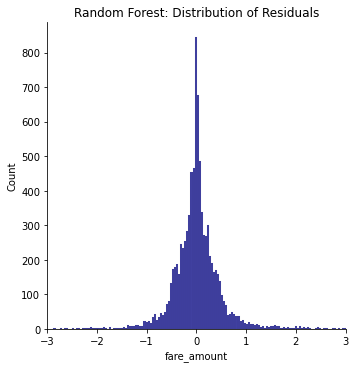

In [49]:
import seaborn as sns
residuals = predictions - y_test
plot = sns.displot(residuals, color = 'navy')
plot.set(title ='Random Forest: Distribution of Residuals', xlim = (-3,3))

resid_mean = (residuals.mean())
print(resid_mean)

### Extracting feature importances

coefficients = pd.DataFrame(
        {"Name":X_train.columns,
         (str(y_train.name)+"_coefs"):regressor.get_feature_importance()}
        )

In [50]:
coefficients = pd.DataFrame(
        {"Name":X_train.columns,
         (str(y_train.name)+"_coefs"):regressor.feature_importances_}
        )

In [51]:
coefficients.sort_values(by = 'fare_amount_coefs', ascending = False)

,Name,fare_amount_coefs
1,time_taken,0.700845
0,trip_distance,0.211837
475,trip_type_2.0,0.019993
474,trip_type_1.0,0.018932
489,hour_6,0.001408
...,...,...
58,PULocationID_64,0.000000
368,DOLocationID_154,0.000000
221,DOLocationID_1,0.000000
224,DOLocationID_5,0.000000


The top 3 coefficients that are important in predicting fare amount include trip distance, time taken and trip type.

### Interpreting model results further using SHAP

In [52]:
import shap
# For reference: https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/Census%20income%20classification%20with%20XGBoost.html

In [ ]:
explainer = shap.TreeExplainer(regressor)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

In [ ]:
shap.summary_plot(shap_values, X_train)

In [ ]:
for name in X_train.columns:
    shap.dependence_plot(name, shap_values, X_train, display_features=X_train)